In [11]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [12]:
# from model.modules.cadCAD import *
# import model.config as config
from model.helpers import *

# Bonding curve functions

In [13]:
# Source: BlockScience modelling for CIC
# https://gitlab.com/grassrootseconomics/cic-modeling

#value function for a given state (R,S)
def invariant(R,S,kappa):
    return (S**kappa)/R

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def reserve(S, V0, kappa):
    return (S**kappa)/V0

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return Supply S as a function of reserve R
def supply(R, V0, kappa):
    return (V0*R)**(1/kappa)

#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#return a spot price P as a function of reserve R
def spot_price(R, V0, kappa):
    return kappa*R**((kappa-1)/kappa)/V0**(1/kappa)

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#deposit deltaR to Mint deltaS
#with realized price deltaR/deltaS
def mint(deltaR, R,S, V0, kappa):
    deltaS = (V0*(R+deltaR))**(1/kappa)-S
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    deltaS = round(deltaS,2)
    return deltaS, realized_price

#for a given state (R,S)
#given a value function (parameterized by kappa)
#and an invariant coeficient V0
#burn deltaS to Withdraw deltaR
#with realized price deltaR/deltaS
def withdraw(deltaS, R,S, V0, kappa):
    deltaR = R-((S-deltaS)**kappa)/V0
    if deltaS ==0:
        realized_price = spot_price(R+deltaR, V0, kappa)
    else:
        realized_price = deltaR/deltaS
    deltaR = round(deltaR,2)
    return deltaR, realized_price

# Called in constructor by minter along with required collateral
def initialize_curve(S0, P0, kappa):
    initial_reserve = P0 * S0 / kappa
    hatch_price = spot_price(R, V0, kappa)
    return initial_reserve, hatch_price

# Initialize bonding curve

Suppose, we would like to issue a token with an initial supply of dev + inv to be pre-allocated to developers and investors, respectively. Investors obtain their tokens at a pre-sale price p after which the price is free-floating, subject to market forces of available supply and demand.

Further Conditions:
* If the sale of inv tokens is unsuccessful, investors are refunded in full.
* If the initial sale is successful, most of the collected funds must be available for developers, without them having to sell their tokens.
* The rest is used for funding the bonding curve contracts market making.


> ... in the initial sale phase, while x < inv, a different, constant function, f(x) = p is used and no other tokens are allowed to exist. When the sale concludes successfully (i.e. x = inv), dev tokens are allocated to developers and the final price function is activated. At this point the price should still be p to prevent discontinuities.

Source: https://gist.github.com/nagydani/d5c09c331224bfbffbcbe28b347ceb8e

In [14]:
from math import isclose

initial_raise_widget = widgets.IntSlider(min=1e6, max=10e6, step=500e3, value=3e6)
kappa_widget = widgets.FloatSlider(min=1, max=10, step=0.5, value=4)
P0_widget = widgets.FloatSlider(min=0.1, max=10, step=0.1, value=1)

def check_funding(
        initial_raise = 3e6,
        premine = 3e6,
        kappa = 4,
        P0 = 1,
    ):
    
    initial_market_cap = initial_raise + premine
    R0 = initial_market_cap / kappa
    S0 = kappa * R0 / P0
    V0 = invariant(R0,S0,kappa)
    P = spot_price(R0, V0, kappa)
    
    investor_supply = initial_raise / P0
    developer_supply = S0 - investor_supply

    print(f'Initial reserve R0: {millify(R0)}')
    print(f'Initial supply S0: {millify(S0)}')
    print()
    print(f'Investor supply: {millify(investor_supply)}')
    print(f'Developer supply: {millify(developer_supply)}')
    print()

    assert S0 == investor_supply + developer_supply

    # Assert mint and withdraw are accurate
    purchase_value = 1e6
    deltaS, _ = mint(purchase_value, 0, 0, V0, kappa)
    deltaR, _ = withdraw(deltaS, purchase_value, deltaS, V0, kappa)

    assert deltaR == purchase_value

    # Best case: liquid funds (not in reserve) available from investor funding
    deltaR, _realized_price = withdraw(S0, R0, S0, V0, kappa)
    liquid_funds = initial_raise - deltaR
    print(f'Liquid funds: {millify(liquid_funds)}')
    print()

    # Worst case: developer/premine token supply used for funding, after everyone has withdrawn
    # Investors withdraw
    deltaR, realized_price = withdraw(investor_supply, R0, S0, V0, kappa)
    remaining_reserve = R0 - deltaR
    print(f'Remaining reserve: {millify(remaining_reserve)}')
    print()

    # Developer tokens withdrawn for funding
    #developer_reserve, realized_price = withdraw(developer_supply, remaining_reserve, developer_supply, V0, kappa)
    #print(f'Developer reserve: {millify(developer_reserve)}')
    #print(f'Realized price: {millify(realized_price)}')
    #print()

    #assert isclose(remaining_reserve, developer_reserve, abs_tol=10**-2)

interact(
    check_funding,
    initial_raise=initial_raise_widget,
    premine=fixed(3e6),
    kappa=kappa_widget,
    P0=P0_widget
);

interactive(children=(IntSlider(value=3000000, description='initial_raise', max=10000000, min=1000000, step=50…

In [33]:
initial_raise = 3e6
premine = 3e6
# TODO: this description is incorrect
# 6M DAI worth of tokens issued initially
initial_market_cap = initial_raise + premine

kappa = 4 # leverage
P0 = 1 # initial spot price
R0 = initial_market_cap / kappa
# R0 = 1e6
initial_market_cap = R0 * kappa
S0 = kappa * R0 / P0
V0 = invariant(R0,S0,kappa)
P = spot_price(R0, V0, kappa)

investor_supply = initial_raise / P0
developer_supply = S0 - investor_supply

print(f'Initial reserve R0: {millify(R0)}')
print(f'Initial supply S0: {millify(S0)}')
print()
print(f'Investor supply: {millify(investor_supply)}')
print(f'Developer supply: {millify(developer_supply)}')

assert S0 == investor_supply + developer_supply

# Assert mint and withdraw are accurate
purchase_value = 1e6
deltaS, _ = mint(purchase_value, 0, 0, V0, kappa)
deltaR, _ = withdraw(deltaS, purchase_value, deltaS, V0, kappa)

assert deltaR == purchase_value

Initial reserve R0: 1.500 Million
Initial supply S0: 6.000 Million

Investor supply: 3.000 Million
Developer supply: 3.000 Million


# Best and worst case funding scenarios

The best case is that the investor funding goal of \$3 mil is met, and the liquid funding available for the project is the difference between the investment value and the collateral required for providing bonding curve liquidity.

In the worst case, all contributors including investors withdraw their funds. This leaves the value of the developer token supply available for project funding.

From the original spec and bonding curve design, the best and worst case funding scenarios were:
* Best case: \$2mil funding
* Worst case: \$100k funding

In [34]:
from math import isclose

# Best case: liquid funds (not in reserve) available from investor funding
deltaR, realized_price = withdraw(S0, R0, S0, V0, kappa)
liquid_funds = initial_raise - deltaR
print(f'Liquid funds: {millify(liquid_funds)}')
print(f'Realized price: {realized_price}')
print()

# Worst case: developer/premine token supply used for funding, after everyone has withdrawn
# Investors withdraw
deltaR, realized_price = withdraw(investor_supply, R0, S0, V0, kappa)
remaining_reserve = R0 - deltaR
print(f'Remaining reserve: {millify(remaining_reserve)}')
print(f'Realized price: {realized_price}')
print()

# # Developer tokens withdrawn for funding
# developer_reserve, realized_price = withdraw(developer_supply, remaining_reserve, developer_supply, V0, kappa)
# print(f'Developer reserve: {millify(developer_reserve)}')
# print(f'Realized price: {realized_price}')
# print()

assert isclose(remaining_reserve, developer_reserve, abs_tol=10**-2)

Liquid funds: 1.500 Million
Realized price: 0.25

Remaining reserve: 93.750 Thousand
Realized price: 0.46875



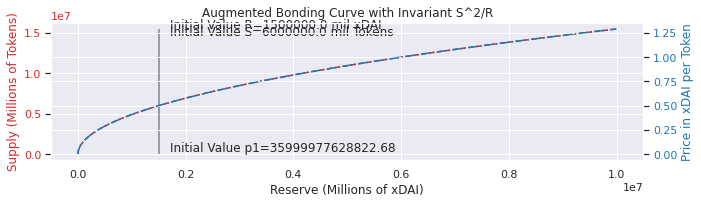

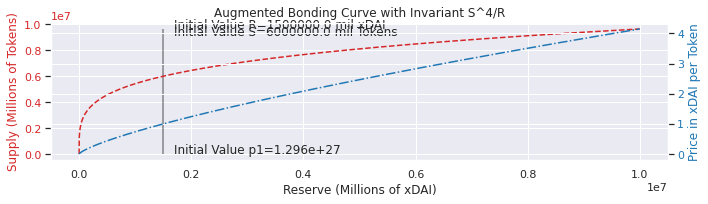

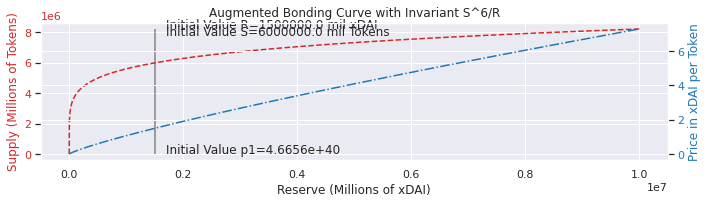

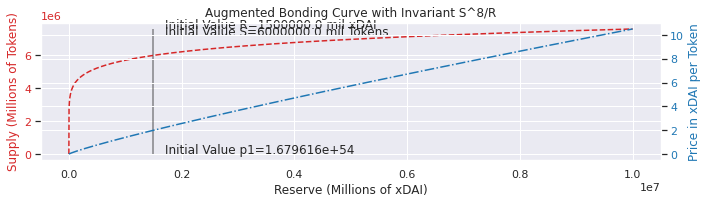

In [51]:
Kappa_List = [2,4,6,8]
for kappa in Kappa_List:
    
    V0 = invariant(R0, S0, kappa)
    
    reserve = np.arange(0,10e6,1e3)
    supp = np.array([supply(r, V0, kappa) for r in reserve])
    price = np.array([spot_price(r, V0, kappa) for r in reserve])

    fig, ax1 = plt.subplots(figsize=(10,3))

    color = 'tab:red'
    ax1.set_xlabel('Reserve (Millions of xDAI)')
    ax1.set_ylabel('Supply (Millions of Tokens)', color=color)
    ax1.plot(reserve, supp,'--', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Price in xDAI per Token', color=color)  # we already handled the x-label with ax1
    ax2.plot(reserve, price,'-.', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.vlines(R0,0,supp[-1], alpha=.5)
    ax1.text(R0+.02*reserve[-1], supp[-1], "Initial Value R="+str(int(100*R0)/100)+" mil xDAI")
    ax1.text(R0+.02*reserve[-1], .95*supp[-1], "Initial Value S="+str(int(100*S0)/100)+" mil Tokens")
    #ax1.hlines(S0,0,R0)

    ax2.text(R0+.02*reserve[-1], price[3], "Initial Value p1="+str(int(1000*spot_price(R0,kappa,V0))/1000))


    plt.title('Augmented Bonding Curve with Invariant S^'+str(kappa)+'/R')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

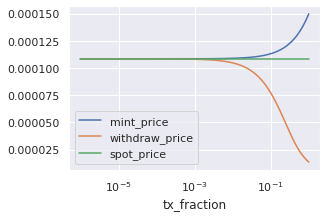

In [52]:
import pandas as pd

#given V0 and kappa
R = 20
S = supply(R, V0, kappa)
p = spot_price(R, V0, kappa)
#sweep the transaction fraction
TXF = np.logspace(-6, 0, num=1000)

#realized price for withdrawing burning .1% of tokens
withdraw_price2=[withdraw(S*txf, R,S, V0, kappa)[1] for txf in TXF]

#realized price for depositing .1% more Xdai into the reserve
mint_price2=[mint(R*txf, R,S, V0, kappa)[1] for txf in TXF]

pdf2 = pd.DataFrame({'tx_fraction':TXF, 'spot_price':p*np.ones(len(TXF)), 'mint_price':mint_price2,'withdraw_price':withdraw_price2 })
pdf2.plot(x='tx_fraction',y=['mint_price','withdraw_price','spot_price'], logx=True)

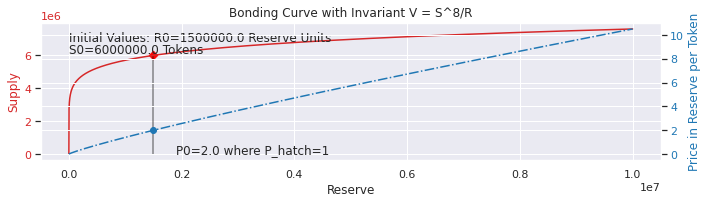

In [59]:
reserve = np.arange(0,10e6,1e3)
supp = np.array([supply(r, V0, kappa) for r in reserve])
price = np.array([spot_price(r, V0, kappa) for r in reserve])

fig, ax1 = plt.subplots(figsize=(10,3))

color = 'tab:red'
ax1.set_xlabel('Reserve')
ax1.set_ylabel('Supply', color=color)
ax1.plot(reserve, supp,'-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Price in Reserve per Token', color=color)  # we already handled the x-label with ax1
ax2.plot(reserve, price,'-.', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.vlines(R0,0,S0, alpha=.5)
ax1.scatter(R0,S0, color='red', marker='D')

ax1.text(-.4, .9*supp[-1], "Initial Values: R0="+str(int(100*R0)/100)+" Reserve Units")
ax1.text(-.4, .80*supp[-1], "S0="+str(S0)+" Tokens")

ax2.text(R0+.04*reserve[-1], price[25], "P0="+str(spot_price(R0, V0, kappa))+" where P_hatch="+str(P0))
ax2.scatter(R0,spot_price(R0, V0, kappa), color=color)

plt.title('Bonding Curve with Invariant V = S^'+str(kappa)+'/R')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# cadCAD Modelling

## Statistical distribution of investment

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import poisson
import seaborn as sns

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(4.5,3)})

181.49318418721776
7831.9559656460115
1141986.658478427


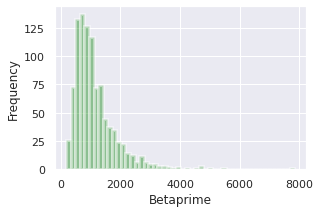

In [18]:
import numpy as np
from scipy.stats import betaprime

# Source: https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like

data_betaprime = betaprime.rvs(a=5.00, loc=100.00, scale=1000.00, b=6.00, size=1000)
ax = sns.distplot(data_betaprime,
                  kde=False,
                  color='green',
                  hist_kws={"linewidth": 3})
ax.set(xlabel='Betaprime', ylabel='Frequency')

print(min(data_betaprime))
print(max(data_betaprime))
print(sum(data_betaprime))

distribution_chunks = np.array_split(data_betaprime, config.timesteps)
def get_distribution_point(x):
    return sum(distribution_chunks[x])

## Model configuration

In [ ]:
from enum import Enum, auto
class Pool(Enum):
    reserve = auto()
    investment = auto()
    
class Edge(Enum):
    balance = auto()
    
def add_node(network, node):
    network.add_node(node.name, _type=node.__class__.__name__)

def initialize_network():
    logger.info('Initializing network')
    network = nx.Graph()
    color_map = []
    
    add_node(network, Pool.reserve)
    add_node(network, Pool.investment)
    
    return (network, color_map)
    
def network_genesis(network, _params, state):
    logger.info('Network genesis')
    initial_supply = _params['']
    
    
    return network

In [ ]:
def sweep_range(params):
    max_len = 1
    for key in params:
        param_length = len(params[key])
        if param_length > max_len:
            max_len = param_length
    return list(range(1, max_len + 1)) or [1] 

parameters: Dict[str, List[int]] = {
    'initial_raise': [3e6],
    'premine': [3e6],
    'kappa': [4],
    'P0': [1],
#     'investor_contribution_distribution': [
#         get_distribution_point
#     ],
#     'user_contribution_distribution': [
#         get_distribution_point
#     ],
}

parameters['sweep'] = sweep_range(params)

initial_state = {
    'genesis': False,
    'invariant': 0,
    'total_investment': 0,
    'available_investment': 0,
    'token_supply': 0,
    'reserve_pool': 0,
    'policies': {},
}

In [ ]:
network, color_map = initialize_network()

pos = nx.drawing.nx_agraph.graphviz_layout(network, prog='dot')

plt.figure()
nx.draw(
    network, pos, edge_color='black', width=2, linewidths=1,
    node_size=800, node_color='pink', alpha=0.9,
    labels={node: node for node in network.nodes()})

nx.draw_networkx_edge_labels(
    network, pos,
    edge_labels={(u,v): d['_type'] for u,v,d in network.edges(data=True)},
    font_color='red')

plt.axis('off')
plt.show()

initial_state.update({
    'network': network,
})

In [ ]:
def check_genesis(_params, step, sL, s):
    genesis = False
    if s['timestep'] == 0:
        logger.info('Genesis')
        genesis = True
        
    return ({'genesis': genesis})

def perform_genesis(_params, step, sL, s, _input):
    network = s['network']
    
    genesis = _input['genesis']
    if genesis:
        logging.info('Perform genesis')
        network = network_genesis(network, _params, s)
        
    return ('network', network)

In [9]:
import pprint
from typing import Dict, List

import pandas as pd
from tabulate import tabulate

from cadCAD.configuration import append_configs
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs

pp = pprint.PrettyPrinter(indent=4)

# Policies
def investor_contribution(_params, step, sH, s):
    #contribution = _params['investor_contribution_distribution'](step)
    contribution = 
    return {'investor_contribution': contribution}

def user_contribution(_params, step, sH, s):
    #contribution = _params['user_contribution_distribution'](step)
    return {'user_contribution': contribution}

# Internal States
def reserve_ratio(_params, step, sH, s, _input):
    return 'invariant', _params['invariant']

def update_investment(_params, step, sH, s, _input):
    return 'total_investment', s['total_investment'] + _input['investor_contribution']

def update_reserve_pool(_params, step, sH, s, _input):
    _params['primitive_function']()
    return 'reserve_pool', s['reserve_pool'] + _input['investor_contribution']

sim_configs = config_sim(
    {
        'N': config.runs,
        'T': config.timesteps,
        'M': parameters,
    }
)

partial_state_update_blocks = [
    { # Genesis
        'policies': {
            'genesis': check_genesis,
        },
        'variables': {
            'network': perform_genesis,
        }
    },
    {
        'policies': {
            'investor_contribution': investor_contribution
        },
        'variables': {
            'reserve_pool': update_reserve_pool,
            'total_investment': update_investment
        }
    },
    {
        'policies': {
            'user_contribution': user_contribution
        },
        'variables': {
        }
    },
]

append_configs(
    sim_configs=sim_configs,
    initial_state=initial_state,
    #env_processes=env_process,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)
run = Executor(exec_context=local_proc_ctx, configs=configs)

i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = sim_configs[i]
    i += 1

Configurations Length: 1
Execution Method: local_simulations
Execution Mode: single_threaded


TypeError: list indices must be integers or slices, not str